<head>
  <meta name="author" content="Gustavo Rocha">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

### 𝟮5.𝟬𝟰 Seg 𝟮𝟭:𝟬𝟬𝗵 𝗮̀𝘀 𝟮𝟮:𝟬𝟬𝗵 
# **ARIMAX Aplicando Modelos de Autoregressão para Séries Temporais com o uso de Variáveis Exógenas**

Aplicação e avaliação de modelos ArimaX com Python e o pacote statsmodel.

*Mackenzie EE Prof. Gustavo Rocha da Silva*

<br>

<br>

___


In [ ]:
pip install pmdarima

In [ ]:
#@markdown Bibliotecas básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(16,8))

In [ ]:
#@markdown Bibliotecas Time Series

import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as qqplot
import scipy.stats as stats

from pmdarima import auto_arima

In [ ]:
#df = pd.read_csv('Marketing_Sales', parse_dates=True, index_col='data')
df = pd.read_csv('uschange_1.csv',parse_dates=True)
df.head()

,Date,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
2,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
3,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1


In [ ]:
df['date'] = pd.to_datetime( df['Date'].str[:4] + "-" + df['Date'].str[-2:])

In [ ]:
df.dtypes
#df.head()

Date                    object
Consumption            float64
Income                 float64
Production             float64
Savings                float64
Unemployment           float64
date            datetime64[ns]
dtype: object

In [ ]:
df = df.set_index("date")
df.isnull().sum()

Date            0
Consumption     0
Income          0
Production      0
Savings         0
Unemployment    0
dtype: int64

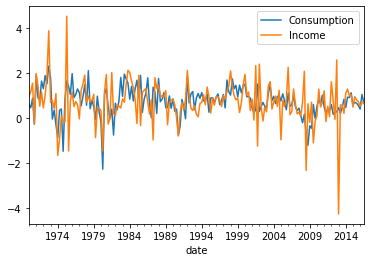

In [ ]:
df[['Consumption','Income']].plot()
plt.show()

Podemos utilizar o teste de Dickey Fuller para observar que as duas séries possuem tendência.

<Figure size 1152x360 with 0 Axes>

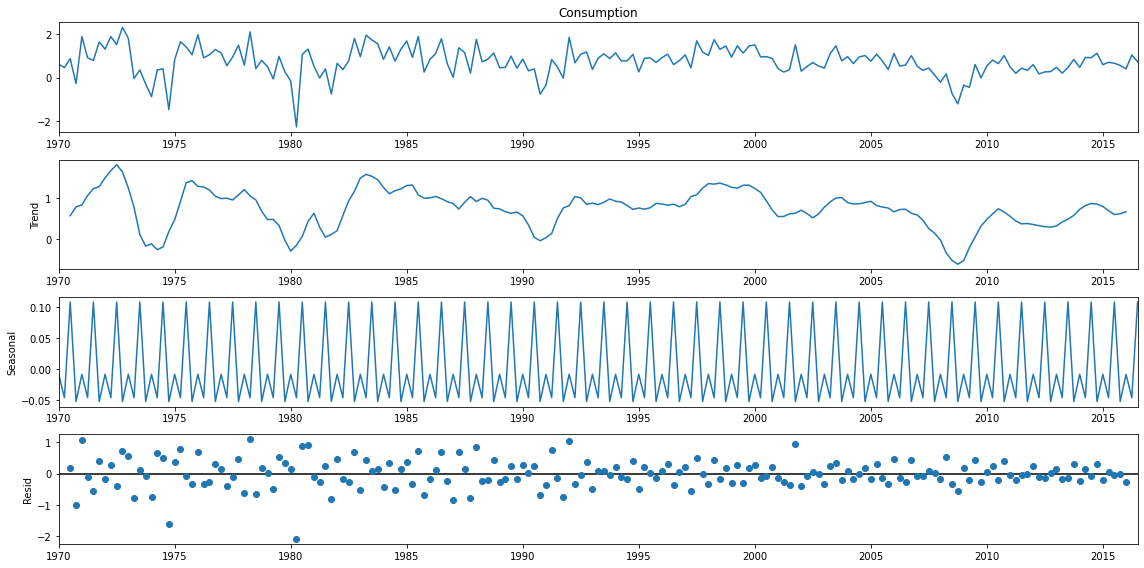

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 5)
result = seasonal_decompose(df['Consumption'], model='add')
result.plot();

In [ ]:
#é possível acessar individualmente as componentes
result.resid
result.seasonal
result.trend

date
1970-01-01         NaN
1970-04-01         NaN
1970-07-01    0.579900
1970-10-01    0.796525
1971-01-01    0.842696
                ...   
2015-07-01    0.608814
2015-10-01    0.627314
2016-01-01    0.677838
2016-04-01         NaN
2016-07-01         NaN
Name: trend, Length: 187, dtype: float64

In [ ]:
#código auxiliar para a verificação da estacionaridade (Realiza o teste Augmented Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df['Consumption'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.522487
p-value                   0.000179
# lags used               2.000000
# observations          184.000000
critical value (1%)      -3.466398
critical value (5%)      -2.877380
critical value (10%)     -2.575214
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
adf_test(df['Income'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.515469e+01
p-value                 6.720576e-28
# lags used             0.000000e+00
# observations          1.860000e+02
critical value (1%)    -3.466005e+00
critical value (5%)    -2.877208e+00
critical value (10%)   -2.575122e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Logo como podemos verificar acima as duas séries são estacionárias. 

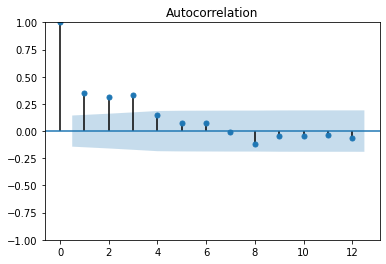

In [ ]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf
x=plot_acf(df['Consumption'], lags=12)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


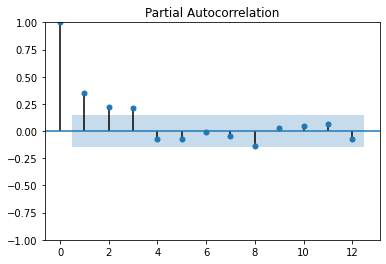

In [ ]:
x=plot_pacf(df['Consumption'], lags=12);

Você pode testar para outras séries do dataset também.

In [ ]:
#x=plot_pacf(df['?'], lags=12);

# Ajustando um modelo ARIMA automaticamente
A função auto_arima irá nos ajudar a varrer o espaço de parâmetros e encontrar os valores (p,d,q)$\times$(P,D,Q)(m)

In [ ]:
#No caso de um modelo com sazonalidade, utilizamos seasonal=True e usamos o valor m para setar a sazonalidade
auto_arima(df['Consumption'],seasonal=True,m=4, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=343.154, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=375.632, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=355.235, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=361.078, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=529.744, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=342.517, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=342.284, Time=0.40 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=343.093, Time=0.72 sec
 ARIMA(1,0,2)(0,0,0)[4] intercept   : AIC=343.330, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=344.493, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[4] intercept   : AIC=342.536, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[4] intercept   : AIC=343.179, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=343.815, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[4] intercept   : AIC=341.613, Time=0.26 sec
 ARIMA(1,0,3)(1,0,0)[4] intercept   : AIC=343.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -164.807
Date:                Thu, 28 Apr 2022   AIC                            341.613
Time:                        11:21:29   BIC                            361.000
Sample:                             0   HQIC                           349.469
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3066      0.096      3.199      0.001       0.119       0.494
ar.L1          0.5887      0.132      4.458      0.000       0.330       0.847
ma.L1         -0.3529      0.138     -2.552      0.011      -0.624      -0.082
ma.L2          0.0846      0.065      1.309      0.190      -0.042       0.211
ma.L3          0.1738      0.079      2.214      0.027       0.020       0.328
sigma2         0.3405      0.025     13.646      0.000       0.292       0.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.65
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Vamos ajustar um modelo SARIMAX 
Primeiro vamos quebrar em conjuntos de treino e teste e depois ajustar o modelo e usar as métricas de erro. 

In [ ]:
len(df)

187

In [ ]:
#6 quarters para teste
train = df.iloc[:170]
test = df.iloc[170:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Consumption'],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  170
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -165.057
Date:                Thu, 28 Apr 2022   AIC                            340.113
Time:                        11:21:29   BIC                            355.792
Sample:                    01-01-1970   HQIC                           346.476
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9298      0.041     22.772      0.000       0.850       1.010
ma.L1         -0.6041      0.064     -9.429      0.000      -0.730      -0.479
ma.L2          0.0510      0.067      0.759      0.448      -0.081       0.183
ma.L3          0.0769      0.075      1.028      0.304      -0.070       0.224
sigma2         0.4053      0.034     11.853      0.000       0.338       0.472
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                19.93
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,3)(0,0,0,4) Predictions')

[Text(0, 0.5, 'Consumption'), Text(0.5, 0, 'Date')]

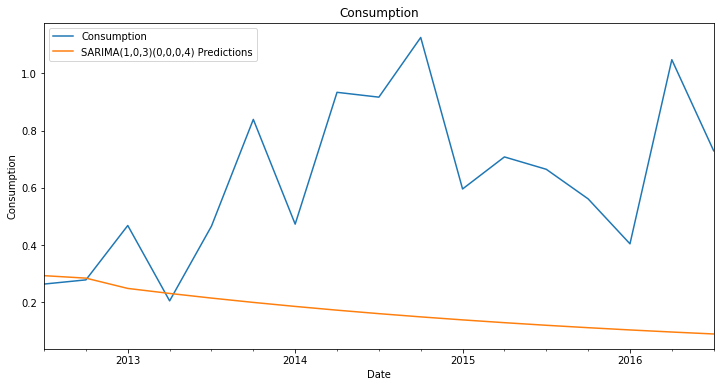

In [ ]:
# Plot predictions against known values
title='Consumption'
ylabel='Consumption'
xlabel='Date'

ax = test['Consumption'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Consumption'],order=(3,0,0),seasonal_order=(2,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Consumption   No. Observations:                  170
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 4)   Log Likelihood                -161.296
Date:                           Thu, 28 Apr 2022   AIC                            334.592
Time:                                   11:21:31   BIC                            353.407
Sample:                               01-01-1970   HQIC                           342.227
                                    - 04-01-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3256      0.055      5.958      0.000       0.218       0.433
ar.L2          0.2697      0.062      4.361      0.000       0.149       0.391
ar.L3          0.3137      0.065      4.798      0.000       0.186       0.442
ar.S.L4       -0.0586      0.072     -0.811      0.417      -0.200       0.083
ar.S.L8       -0.1794      0.073     -2.445      0.014      -0.323      -0.036
sigma2         0.3869      0.036     10.656      0.000       0.316       0.458
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                17.01
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,3)(0,0,0,4) Predictions')

[Text(0, 0.5, 'Consumption'), Text(0.5, 0, 'Date')]

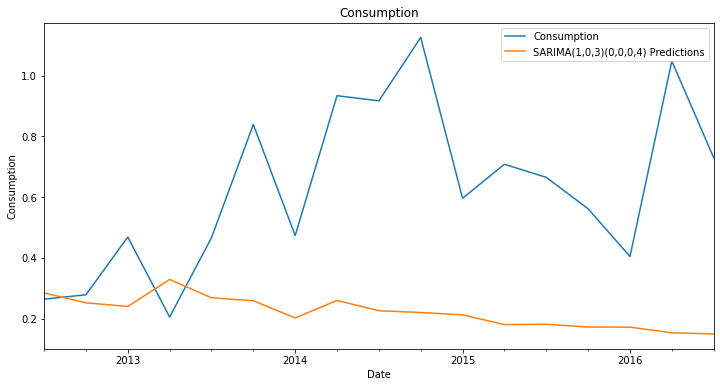

In [ ]:
# Plot predictions against known values
title='Consumption'
ylabel='Consumption'
xlabel='Date'

ax = test['Consumption'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['Consumption'], predictions)
error2 = rmse(test['Consumption'], predictions)

print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error:  0.25106934
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.501068199


## Vamos agora fazer o mesmo procedimento adicionando a variável exógena Income

In [ ]:
model = SARIMAX(train['Consumption'],exog=train[['Income']],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  170
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -152.737
Date:                Thu, 28 Apr 2022   AIC                            317.474
Time:                        11:21:32   BIC                            336.289
Sample:                    01-01-1970   HQIC                           325.109
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Income         0.2948      0.043      6.898      0.000       0.211       0.379
ar.L1          0.9974      0.005    220.628      0.000       0.989       1.006
ma.L1         -0.9037      0.072    -12.633      0.000      -1.044      -0.763
ma.L2          0.2006      0.100      2.008      0.045       0.005       0.396
ma.L3         -0.2366      0.073     -3.252      0.001      -0.379      -0.094
sigma2         0.3494      0.031     11.258      0.000       0.289       0.410
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                17.12
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Income']]
predictions = results.predict(start=start, end=end,exog=exog_forecast).rename('SARIMA(1,0,3)(0,0,0,4) Predictions')

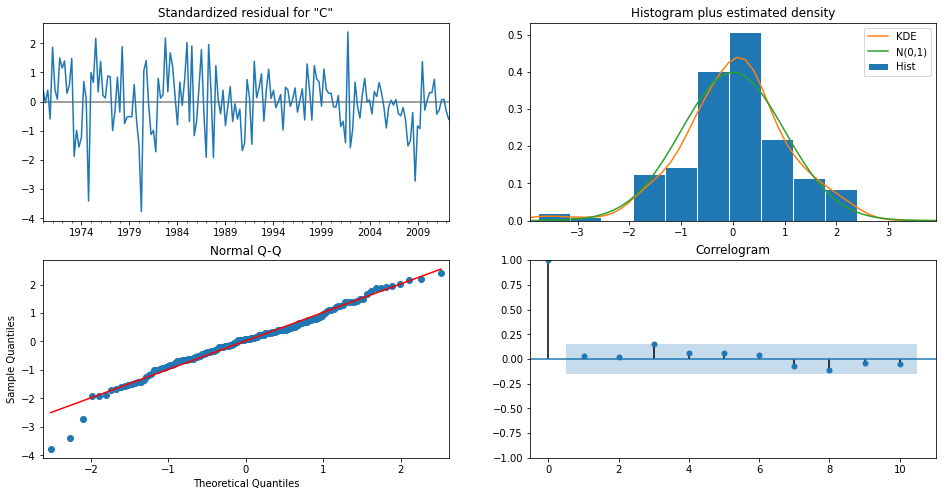

In [ ]:
plt.rc("figure", figsize=(16,8))
results.plot_diagnostics()
plt.show()

[Text(0, 0.5, 'Consumption'), Text(0.5, 0, 'Date')]

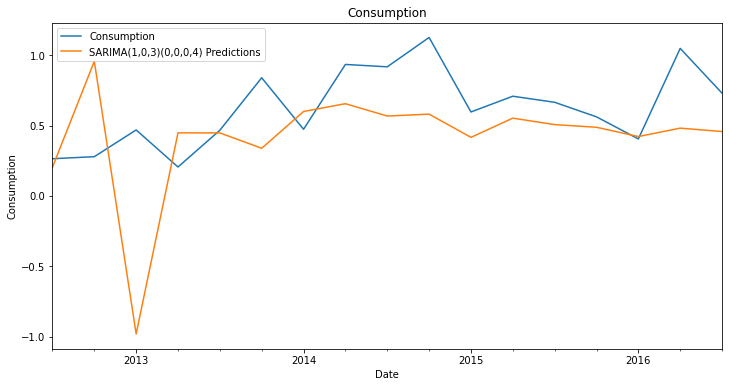

In [ ]:
# Plot predictions against known values
title='Consumption'
ylabel='Consumption'
xlabel='Date'

ax = test['Consumption'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Imprimir os valores comparativos dos modelos

In [ ]:
# Print values from SARIMA above
print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['Consumption'], predictions)
error2x = rmse(test['Consumption'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,3)(0,0,0,4) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,3)(0,0,0,4) RMSE Error: {error2x:11.10}')
print(test['Consumption'].mean())

SARIMA(1,0,3)(0,0,0,4) MSE Error:  0.25106934
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.501068199

SARIMAX(1,0,3)(0,0,0,4) MSE Error: 0.2274455363
SARIMAX(1,0,3)(0,0,0,4) RMSE Error: 0.4769125038
0.6285310447058823


## Retreinar o modelo no conjunto total dos dados



In [ ]:
df.columns

Index(['Date', 'Consumption', 'Income', 'Production', 'Savings',
       'Unemployment'],
      dtype='object')

In [ ]:
model = SARIMAX(train['Consumption'],exog=train[['Income', 'Production', 'Savings',
       'Unemployment']],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  170
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 -72.838
Date:                Thu, 28 Apr 2022   AIC                            163.675
Time:                        04:40:49   BIC                            191.897
Sample:                    01-01-1970   HQIC                           175.127
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Income           0.8895      0.037     24.117      0.000       0.817       0.962
Production       0.0946      0.031      3.092      0.002       0.035       0.155
Savings         -0.0515      0.003    -19.908      0.000      -0.057      -0.046
Unemployment     0.1073      0.143      0.752      0.452      -0.172       0.387
ar.L1           -0.2110      3.504     -0.060      0.952      -7.079       6.657
ma.L1            0.1739      3.543      0.049      0.961      -6.770       7.117
ma.L2            0.1702      0.125      1.362      0.173      -0.075       0.415
ma.L3            0.0144      0.658      0.022      0.983      -1.275       1.303
sigma2           0.1379      0.013     10.949      0.000       0.113       0.163
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                17.07
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Income', 'Production', 'Savings',
       'Unemployment']]
predictions = results.predict(start=start, end=end,exog=exog_forecast).rename('SARIMA(1,0,3)(0,0,0,4) Predictions')

[Text(0, 0.5, 'Consumption'), Text(0.5, 0, 'Date')]

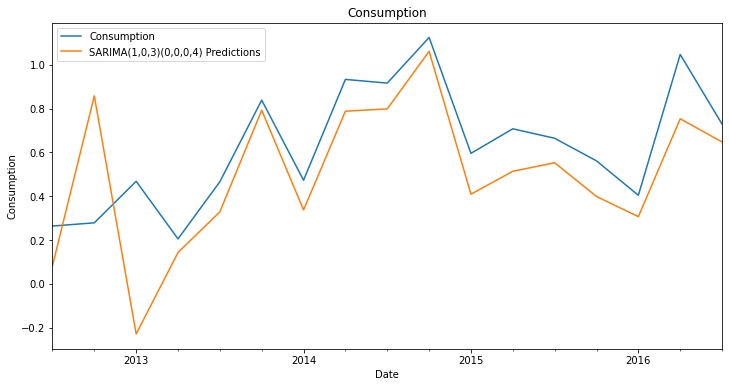

In [ ]:
# Plot predictions against known values
title='Consumption'
ylabel='Consumption'
xlabel='Date'

ax = test['Consumption'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)